metapa.py

extending the PA model of Fisher + Mehta (2014), Dickens, Fisher, + Mehta (2016) to a metacommunity framework.

parameters:

$\lambda$: 
$\mu_c$, $\sigma_c$: 
$\mu_K$, $\sigma_K$:
$\mu_{\delta}$, $\sigma_{\delta}$:
    

In [2]:
import numpy as np
import matplotlib.pyplot as plt



In [39]:
class mpaParams:
    
    # Minimal class for keeping track of model parameters
    
    def __init__(self):
        
        self.lam = .1
        self.mu_c = .1
        self.sig2_c = .05
        self.mu_K = 100
        self.sig2_K = 70.
        self.mu_d = .1
        self.sig2_d = .05
        self.w = 1.
        self.dKcov = .02
        
        self.numsteps = 0
        self.numtrials = 0
        
        self.M = 9
        self.N = 2
        


In [388]:
# check out the params
params = mpaParams()
params.__dict__

{'M': 3,
 'N': 1,
 'lam': 0.0,
 'mu_K': 0.0,
 'mu_c': 0.0,
 'mu_d': 0.0,
 'numsteps': 0,
 'numtrials': 0,
 'sig2_K': 0.0,
 'sig2_c': 0.0,
 'sig2_d': 0.0,
 'w': 1.0}

In [204]:
"""This is the main class for the metapa model."""

class metapa:
    
    def __init__(self):
        """initialze metapa class."""
        
        # mpaParams class for storing and editing parameter values
        self.params = mpaParams()
        
        # species field (MxMxN)
        self.initS()
        
    def initS(self):
        """intialize species field.  currently initializes randomly, uniformly. 
        After changing M or N, need to call initS again to reinitialize.
        
        To do:  add other options, i.e. for invasion studies"""
        
        
        # fraction initialized as 1.  possibly add to mpaParams
        initThresh = .5
        compareThresh = 1-initThresh
        
        # species field s, initialized with uniform random numbers
        self.s = np.random.rand(self.params.M,self.params.M,self.params.N)
        
        # mask with initThresh
        self.s[self.s <= compareThresh] = 0.
        self.s[self.s > compareThresh] = 1.
    
        
    
    def initRates(self):
        """intialize arrays with repeated values of d,K, and l, (MxMxN), 
        and construct interaction matrix, c (NxN).
        To do:  test"""
        
        ##### compute carr from a gamma distribution.  See Dickens, Fisher, Mehta (2016) #####
        k_c = self.params.mu_c*self.params.mu_c/self.params.sig2_c/self.params.N
        theta_c = self.params.sig2_c/self.params.mu_c

        self.carr = np.random.gamma(k_c,scale=theta_c,size = (self.params.N,self.params.N))
        
        ##### compute larr using constant lambda  #####
        self.larr = self.params.lam*np.ones((self.params.M,self.params.M,self.params.N))
        
        ##### compute darr and Karr from a joint lognormal distribution.  let p = (d,K) #####
        ld = np.log(self.params.mu_d*self.params.mu_d/np.sqrt(self.params.mu_d*self.params.mu_d + self.params.sig2_d ))
        z2d = np.log(1+self.params.sig2_d/self.params.mu_d/self.params.mu_d)
        
        lK = np.log(self.params.mu_K*self.params.mu_K/np.sqrt(self.params.mu_K*self.params.mu_K + self.params.sig2_K ))
        z2K = np.log(1+self.params.sig2_K/self.params.mu_K/self.params.mu_K)
        
        z2dK = np.log(1+self.params.dKcov/self.params.mu_K/self.params.mu_d)
        
        cov_arr = np.array([[z2d, -z2dK],
                        [-z2dK, z2K]])
        
        mean_arr = np.array([ld, lK])
        
        #logp = np.random.multivariate_normal(mean_arr,cov_arr,size=self.params.M*self.params.M*self.params.N)
        logp = np.random.multivariate_normal(mean_arr,cov_arr,size=self.params.N)
        
        p = np.exp(logp)
        #self.darr = p[:,0].reshape(self.params.M,self.params.M,self.params.N)
        #self.Karr = p[:,1].reshape(self.params.M,self.params.M,self.params.N)
        Karr = p[:,1].reshape(1,1,self.params.N)
        self.Karr = np.tile(Karr,(self.params.M,self.params.M,1))
        
        darr = p[:,0].reshape(1,1,self.params.N)
        self.darr = np.tile(darr,(self.params.M,self.params.M,1))

        
    def update(self):
        """function for updating in one timestep"""
        
        ####### set things up ########
        
        # generate random numbers for each species at each lattice site
        random_numbers = np.random.rand(self.params.M,self.params.M,self.params.N)
        
        # compute eps
        ############# NEED TO INCLUDE K IN INTERACTION TERM !!!! ###########
        Keff = self.Karr - np.tensordot(self.s*self.Karr,self.carr,axes = 1)
        eps = np.exp(-Keff/self.params.w)
        
        # compute pImmigrate 
        pImmigrate = self.larr*(1-self.s) 
        
        # compute pExtinct
        pExtinct = eps*self.s

        # compute pDisperse
        sLeft = np.roll(self.s,1,axis=1)
        sRight = np.roll(self.s,-1,axis=1)
        sTop = np.roll(self.s,1,axis=0)
        sBottom = np.roll(self.s,-1,axis=0)
        
        pDisperse = self.darr*(1-self.s)*(sLeft+sRight+sTop+sBottom)/4
        
        ####### make transitions #######
        #print(self.s[0,0,0])
        #print(pExtinct[0,0,0])
        # immigrate
        self.s[random_numbers < pImmigrate] = 1
        #if random_numbers[0,0,0] < pImmigrate[0,0,0]:
            #print('?')
            #print(self.s[0,0,0])
            #print(pExtinct[0,0,0])

        # go extinct
        self.s[random_numbers < pExtinct] = 0
        #if random_numbers[0,0,0] < pImmigrate[0,0,0] + pExtinct[0,0,0]:
            #print('!')
            #print(self.s[0,0,0])
        
        # disperse
        self.s[random_numbers < pDisperse] = 1
        
    def evolve(self):
        """run update numsteps times."""
        for n in range(self.params.numsteps):
            self.update()
            
    def simulate(self):
        """evolve for numsteps and numtrials.  compute order parameters"""
        Mmat = np.zeros((self.params.numsteps,self.params.numtrials))
        running_time_average = np.zeros((self.params.M,self.params.M,self.params.N,self.params.numtrials))
        for trial in range(self.params.numtrials):
            self.initS()
            self.initRates()
            
            for step in range(self.params.numsteps):
                Mmat[step,trial] = np.sum(np.sum(np.sum(self.s)))/self.params.M/self.params.M
                #alpha1_mat[step,trial] = 4/self.params.N*np.sum(np.sum(np.sum(self.s*self.s)))
                #alpha2_mat[step,trial] = 4/self.params.N*np.sum(np.sum(np.sum(self.s)))
                
                running_time_average[:,:,:,trial] = self.s
                if step > 200:
                    running_time_average[:,:,:,trial] = (running_time_average[:,:,:,trial] + self.s)/2
                    
                #species1mat[step,trial] = self.s[0,0,0]
                self.update()
                
        self.Marr = np.mean(Mmat,axis=1)
        
        #
        self.alpha = np.mean(running_time_average*running_time_average,axis=3) - np.mean(running_time_average,axis=3)*np.mean(running_time_average,axis=3)
        
        #self.species1mat = species1mat
                
    
            
        
                
                    
                    
    
    
    

In [226]:
'''function for computing composite order parameter from M and alpha.

   I cant figure out linear indexing right now cuz theres no wifi, 
   but that would be a better way of doing this.'''

def computeC(mpa,Marr,alpha,gamma):
    

    C = np.zeros(Marr.shape)
    g = np.zeros(Marr.shape)
    
    if np.array(Marr.shape).size == 2:
        for m in range(Marr.shape[0]):
            for n in range(Marr.shape[1]):
                if Marr[m,n] > gamma:
                    g[m,n] = (gamma-Marr[m,n])/(mpa.params.N-gamma)
                else:
                    g[m,n] = (gamma-Marr[m,n])/gamma
                C[m,n] = (1-alpha[m,n]*4/mpa.params.N/mpa.params.M/mpa.params.M)*g[m,n]
    elif np.array(Marr.shape).size == 1:
        for m in range(Marr.shape[0]):
            if Marr[m] > gamma:
                g[m] = (gamma-Marr[m])/(mpa.params.N-gamma)
            else:
                g[m] = (gamma-Marr[m])/gamma
            C[m] = (1-alpha[m]*4/mpa.params.N/mpa.params.M/mpa.params.M)*g[m]
        
    return C

Here's an example of how to initialize the metapa class.

In [462]:
# initialize lattices with different sizes, species
mpa = metapa()
mpa.params.N = 10
mpa.params.M = 8
mpa.initS()
#print(mpa.__dict__)
print(len(mpa.s), len(mpa.s[0]), len(mpa.s[0][0]))

#print(mpa.s[:,:,0])

8 8 10


First calculation: compute order parameters as a function of mu_c for a single patch model, and compare to original pa model paper.

In [219]:
# compute order parameters as a function of mu_c

# define array of mu_c values
#mu_c_arr = np.array([.1, 1, 4, 8, 12, 16, 20, 24])
mu_c_arr = np.array([.1, 1, 2,3, 4, 5, 6])

# preallocate order parameter arrays
Marr = np.zeros(mu_c_arr.size)
alpha = np.zeros(mu_c_arr.size)

# create instance of metapa class and set parameters
mpa = metapa()
mpa.params.M = 1
mpa.params.N = 20
mpa.params.numsteps = 4000
mpa.params.numtrials = 5
mpa.params.mu_d = .001#2
mpa.params.mu_K = 100
mpa.params.w = 1
mpa.params.lam = .01# 0.
mpa.params.sig2_c = .2
mpa.params.sig2_K = 0
mpa.params.sig2_d = 0

# loop through mu_c values, simulate, and compute order parameters
for m in range(mu_c_arr.size):
    print('m = ', m)
    mpa.params.mu_c = mu_c_arr[m]#*mpa.params.N
    
    # simualte!
    mpa.simulate()
    
    # compute order parameters
    Marr[m] = np.mean(mpa.Marr[np.int(mpa.params.numsteps/2)::])
    alpha[m] = np.sum(np.sum(np.sum(mpa.alpha)))*4/mpa.params.N/mpa.params.M/mpa.params.M


print('done!')            
    

    

m =  0
m =  1
m =  2
m =  3
m =  4
m =  5
m =  6
done!


In [227]:
# compute composite order parameter

gamma = 19
C = computeC(mpa,Marr,alpha,gamma)
print(C)

[-0.7760016   0.28293503  0.54788809  0.67342181  0.74818371  0.81632274
  0.8517877 ]


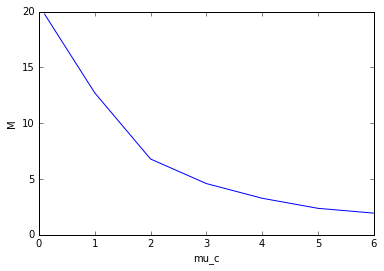

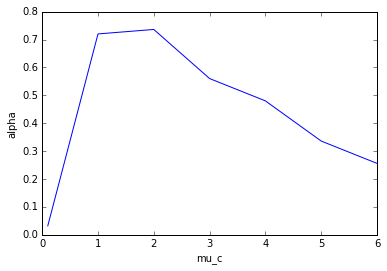

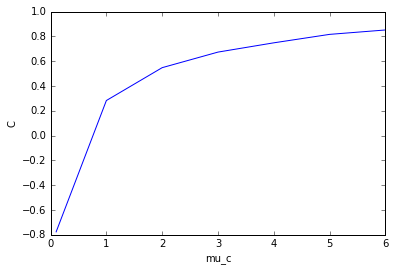

In [229]:
# plot order parameters

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(mu_c_arr,Marr)
plt.ylabel('M')
plt.xlabel('mu_c')
plt.show()

plt.plot(mu_c_arr,alpha)
plt.ylabel('alpha')
plt.xlabel('mu_c')
plt.show()

plt.plot(mu_c_arr,C)
plt.ylabel('C')
plt.xlabel('mu_c')
plt.show()

Second calculation: make phase diagram for mu_c and sig2_c

In [212]:
# compute order parameters as a function of mu_c and sig2_c

# define array of mu_c values
#mu_c_arr = np.array([.1, 1, 4, 8, 12, 16, 20, 24])
mu_c_arr = np.array([.1,.5,1,2,2.5,3,4])

# define array of sig2_c values
sig2_c_arr = (np.array([.01,.05,.1,.15,.2,.3,.4]))**2

# preallocate order parameter arrays
Marr = np.zeros((mu_c_arr.size,sig2_c_arr.size))
alpha = np.zeros((mu_c_arr.size,sig2_c_arr.size))

# create instance of metapa class and set parameters
mpa = metapa()
mpa.params.M = 1
mpa.params.N = 20
mpa.params.numsteps = 4000
mpa.params.numtrials = 5
mpa.params.mu_d = .001#2
mpa.params.mu_K = 100
mpa.params.w = 1
mpa.params.lam = .01# 0.
mpa.params.sig2_K = 0
mpa.params.sig2_d = 0

# loop through mu_c values, simulate, and compute order parameters
for m in range(mu_c_arr.size):
    print('m = ', m)

    for n in range(sig2_c_arr.size):
        mpa.params.mu_c = mu_c_arr[m]#*mpa.params.N
        mpa.params.sig2_c = sig2_c_arr[n]
    
        # simualte!
        mpa.simulate()
    
        # compute order parameters
        Marr[m,n] = np.mean(mpa.Marr[np.int(mpa.params.numsteps/2)::])
        alpha[m,n] = np.sum(np.sum(np.sum(mpa.alpha)))*4/mpa.params.N/mpa.params.M/mpa.params.M


print('done!')            
    

    

m =  0
m =  1
m =  2
m =  3
m =  4
m =  5
m =  6
done!


In [213]:
# compute composite order parameter

gamma = 19
C = computeC(mpa,Marr,alpha,gamma)
print(C)

[[-1.         -1.         -0.98902944 -0.45875184  0.00691597 -0.3986952
   0.00444867]
 [ 0.05582308  0.00829013  0.03994392  0.07820279  0.06176261  0.04562729
   0.13375458]
 [ 0.30838282  0.30094173  0.298986    0.24866898  0.29704133  0.31987887
   0.27876717]
 [ 0.56482653  0.54871667  0.5811266   0.55428801  0.55423921  0.55066643
   0.52240678]
 [ 0.6553952   0.64112653  0.64738403  0.66737505  0.62184487  0.62399861
   0.64125647]
 [ 0.70907091  0.70343967  0.66764909  0.68113947  0.69467633  0.69998147
   0.67219791]
 [ 0.76773655  0.76345186  0.77936569  0.75424458  0.77090601  0.78109693
   0.76701853]]


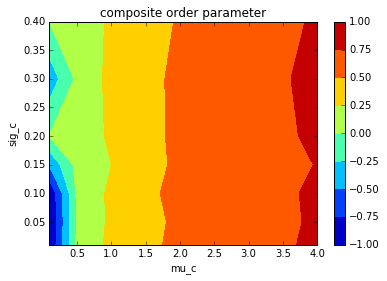

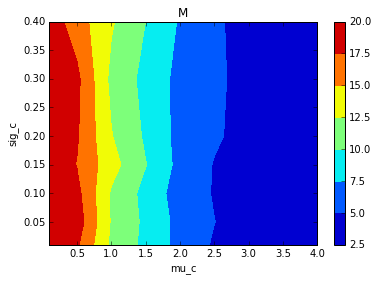

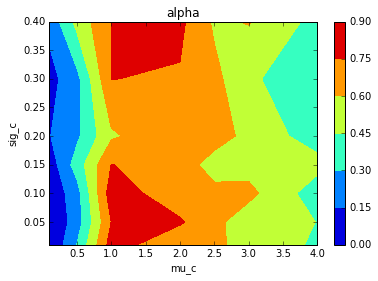

In [216]:
# plot order parameters

%matplotlib inline

c = plt.contourf(mu_c_arr,np.sqrt(sig2_c_arr),C.T)
plt.colorbar(c)
plt.xlabel('mu_c')
plt.ylabel('sig_c')
plt.title('composite order parameter')


plt.show()

c = plt.contourf(mu_c_arr,np.sqrt(sig2_c_arr),Marr.T)
plt.colorbar(c)
plt.xlabel('mu_c')
plt.ylabel('sig_c')
plt.title('M')


plt.show()

c = plt.contourf(mu_c_arr,np.sqrt(sig2_c_arr),alpha.T)
plt.colorbar(c)
plt.xlabel('mu_c')
plt.ylabel('sig_c')
plt.title('alpha')


plt.show()







Third calculation: compute order parameters as a function of mu_c for a MULTI patch model, and compare to original pa model paper.

In [248]:
# compute order parameters as a function of mu_c

# define array of mu_c values
#mu_c_arr = np.array([.1, 1, 4, 8, 12, 16, 20, 24])
mu_c_arr = np.array([.1, 1, 2,3, 4, 5, 6])

# preallocate order parameter arrays
Marr = np.zeros(mu_c_arr.size)
alpha = np.zeros(mu_c_arr.size)

# create instance of metapa class and set parameters
mpa = metapa()
mpa.params.M = 20
mpa.params.N = 20
mpa.params.numsteps = 4000
mpa.params.numtrials = 5
mpa.params.mu_d = .5#2
mpa.params.mu_K = 100
mpa.params.w = 1
mpa.params.lam =  0. #.01
mpa.params.sig2_c = .2
mpa.params.sig2_K = .125
mpa.params.sig2_d = .125
mpa.params.dKcov = .1

# loop through mu_c values, simulate, and compute order parameters
for m in range(mu_c_arr.size):
    print('m = ', m)
    mpa.params.mu_c = mu_c_arr[m]#*mpa.params.N
    
    # simualte!
    mpa.simulate()
    
    # compute order parameters
    Marr[m] = np.mean(mpa.Marr[np.int(mpa.params.numsteps/2)::])
    alpha[m] = np.sum(np.sum(np.sum(mpa.alpha)))*4/mpa.params.N/mpa.params.M/mpa.params.M


print('done!')            
    

    

m =  0
m =  1


KeyboardInterrupt: 

In [246]:
# compute composite order parameter

gamma = 19
C = computeC(mpa,Marr,alpha,gamma)
print(C)

[-0.62497555  0.19786897  0.54186704  0.68022754  0.78145405  0.82740962
  0.85582244]


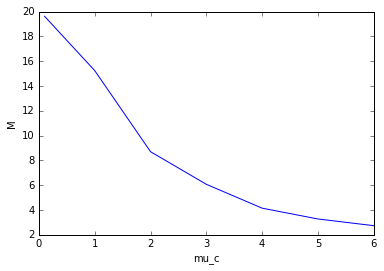

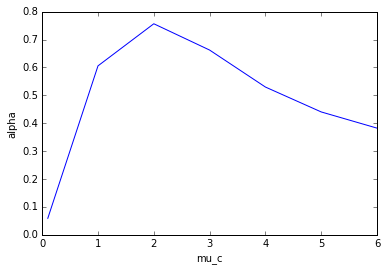

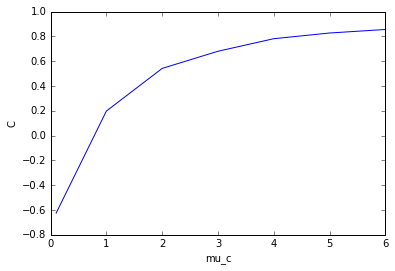

In [247]:
# plot order parameters

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(mu_c_arr,Marr)
plt.ylabel('M')
plt.xlabel('mu_c')
plt.show()

plt.plot(mu_c_arr,alpha)
plt.ylabel('alpha')
plt.xlabel('mu_c')
plt.show()

plt.plot(mu_c_arr,C)
plt.ylabel('C')
plt.xlabel('mu_c')
plt.show()

SCRAP PAPER

In [217]:
Keff = mpa.Karr - mpa.s*np.tensordot(mpa.Karr*mpa.s,mpa.carr,axes = 1)
#print(Keff)
#print(mpa.Karr)
#np.exp(-Keff)

In [113]:
mpa.params.__dict__

{'M': 1,
 'N': 20,
 'dKcov': 0.02,
 'lam': 0.01,
 'mu_K': 100,
 'mu_c': 120,
 'mu_d': 0.001,
 'numsteps': 40000,
 'numtrials': 5,
 'sig2_K': 70.0,
 'sig2_c': 10.0,
 'sig2_d': 0.05,
 'w': 1.0}

In [151]:
print(np.array([.2, .4 ,.6])**2)

[ 0.04  0.16  0.36]


In [237]:
help(np.random.multivariate_normal)

Help on built-in function multivariate_normal:

multivariate_normal(...) method of mtrand.RandomState instance
    multivariate_normal(mean, cov[, size])
    
    Draw random samples from a multivariate normal distribution.
    
    The multivariate normal, multinormal or Gaussian distribution is a
    generalization of the one-dimensional normal distribution to higher
    dimensions.  Such a distribution is specified by its mean and
    covariance matrix.  These parameters are analogous to the mean
    (average or "center") and variance (standard deviation, or "width,"
    squared) of the one-dimensional normal distribution.
    
    Parameters
    ----------
    mean : 1-D array_like, of length N
        Mean of the N-dimensional distribution.
    cov : 2-D array_like, of shape (N, N)
        Covariance matrix of the distribution. It must be symmetric and
        positive-semidefinite for proper sampling.
    size : int or tuple of ints, optional
        Given a shape of, for example

<function matplotlib.pyplot.show>

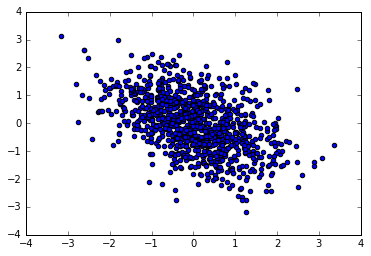

In [244]:
%matplotlib inline

s = -.5
numsamps = 1000
mean = np.array([0,0])
cov = np.array([[1,s],
               [s,1]])
p = np.random.multivariate_normal(mean,cov,numsamps)

x1 = p[:,0]
x2 = p[:,1]

plt.scatter(x1,x2)
plt.show


mpa.params.sig2_c = np.array(.8*20*5)**2

k_c = mpa.params.mu_c*mpa.params.mu_c/mpa.params.sig2_c/mpa.params.N
theta_c = mpa.params.sig2_c/mpa.params.mu_c

carr = np.random.gamma(k_c,scale=theta_c,size = (mpa.params.N,mpa.params.N))

print(np.sqrt(mpa.params.sig2_c/mpa.params.N))
print(np.sqrt(np.var(carr)))
print(mpa.params.mu_c/mpa.params.N)
print(np.mean(carr))

print(np.sqrt(np.var(carr))/np.mean(carr))

In [222]:
test = np.zeros((2,2))
np.array(test.shape).size

2